IR_Fusion based Face Recognition Transfomer Deep Network
----------------------------

'''
Research Reference:
- ECAPA-TDNN - https://github.com/TaoRuijie/ECAPA-TDNN
- face transformer for recognition -  https://arxiv.org/pdf/2103.14803.pdf
- Paper face transformer for recognition - https://github.com/zhongyy/Face-Transformer

Datasets in use
--------------------------
IR_RGB Combo data set used - http://tdface.ece.tufts.edu/downloads/TD_IR_RGB_CROPPED/
in other test --
IR Facial Dataset source:
http://tdface.ece.tufts.edu/downloads/TD_IR_A/
http://tdface.ece.tufts.edu/downloads/TD_IR_E/

Coded everything in multiple .py files, putting in jupyter file just for showcase purpose

batch_size  : 16
train_loader size :  5
Train Labels-------- :  tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Test Labels---------- :  tensor([  1,  10,  11,  12,  13,  14,  15,  16, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113])
Overlapping Data : tensor([16])
Remove overllaping element from train labels and remove bad data
Filtered test labels : tensor([  1,  10,  11,  12,  13,  14,  15, 100, 101, 102, 103, 104, 105, 106,
        107, 108, 109, 110, 111, 112, 113])
rgb :  torch.Size([16, 3, 128, 128])
ir :  torch.Size([16, 3, 128, 128])


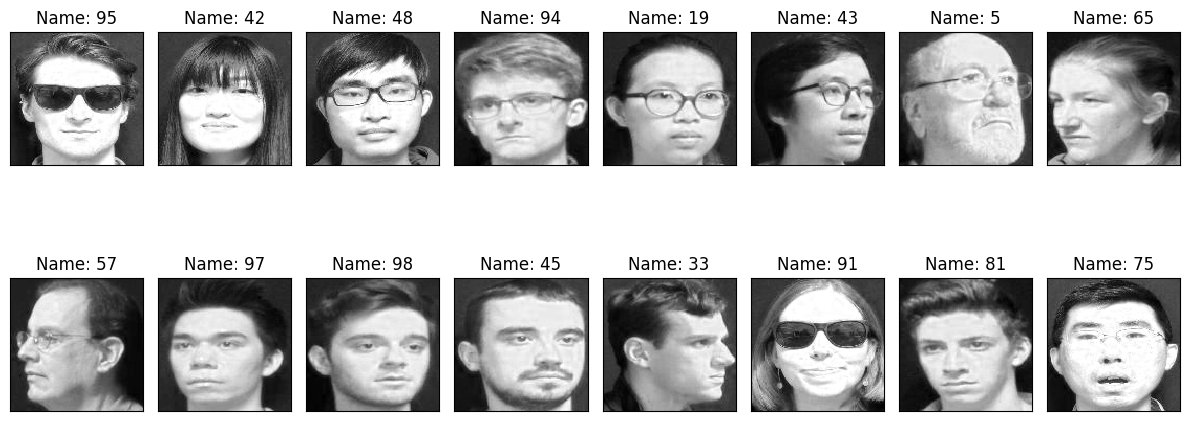

**********Initialising Model Training for K -  0
Using device:  cuda (NVIDIA GeForce RTX 3080 Ti Laptop GPU)
Setting us custom config... {'img_size': 128, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 768, 'depth': 12, 'n_classes': 114, 'n_heads': 12, 'qkv_bias': True, 'mlp_ratio': 4}
Using device:  cuda (NVIDIA GeForce RTX 3080 Ti Laptop GPU)


Training:   0%|          | 0/10 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [1]:
##Training model##
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torchvision
import torch


from tqdm import tqdm, trange
#For graphs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # For dimensionality reduction (optional)

#Import Transformer
from FusionVisionFaceTransfomer import FusionVisionFaceTransfomer
#from  FusionVisionFaceTransfomer import FusionVisionFaceTransfomer
from Load_Dataset import load_IR_RGB_dataset, load_IR_RGB_dataset_kfold
from Utils import show_images
import Utils
from ROC_curve_calculation import filter_train_test
from Eval_Model import evaluate_model





def train_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    #embed()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res[0]


##Graph method
def show_graph(arcface_embeddings, num_samples, embedding_dim, num_classes):
    arcface_embeddings = np.random.rand(num_samples, embedding_dim)
    arcface_embeddings /= np.linalg.norm(arcface_embeddings, axis=1, keepdims=True)  # Normalize embeddings
    class_labels = np.random.randint(0, num_classes, num_samples)  # Assign random class labels

    # Optionally, perform dimensionality reduction for visualization (e.g., using t-SNE)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    reduced_embeddings = tsne.fit_transform(arcface_embeddings)

    # Get unique class labels
    unique_labels = np.unique(class_labels)

    # Create a color map for classes
    num_unique_labels = len(unique_labels)
    color_map = plt.get_cmap('tab20', num_unique_labels)

    # Plot the scatter plot
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(unique_labels):
        indices = np.where(class_labels == label)
        #plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], color=color_map(i), label=f'Class {label}')
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], color=color_map(i))

    plt.title("ArcFace Embeddings Scatter Plot")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()

# Define a function to update the graph
def update_graph(epoch, train_losses, test_accuracies):
    print('Update Loss accuracy graph')
    print('Train losses till now : ', train_losses)
    print('Test accuracy till now : ', test_accuracies)
    plt.figure(figsize=(10, 5))
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_accuracies, label='Test Accuracy')
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    
    plt.legend()
    
    plt.tight_layout()
    #plt.savefig(f'epoch_{epoch}.png')
    plt.show()
    plt.close()




def train(train_loader, test_loader=None, kFold = 1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    #device = "cpu"
    custom_config = {"img_size" :  128,
                 "in_channels" :  3,
                 "patch_size" : 16,
                 "embed_dim" : 768,
                 "depth" : 12,
                 "n_classes" : 114,
                 "n_heads" : 12,
                 "qkv_bias" :  True,
                 "mlp_ratio" :  4
                 }
    print('Setting us custom config...', custom_config)

    model = FusionVisionFaceTransfomer(**custom_config).to(device)

    m = 0.4
    s = 64.0
    n_classes = 114

    #N_EPOCHS = 400
    N_EPOCHS = 10
    LR = 0.001

    #Plotting controller
    epoch_count=0
    epoch_show_limit = 10
    epoch_out = ''

    
    train_losses = []
    test_accuracies = []
    best_eval_score = 0.0
    stable_best_score_epoch_limit = 9
    stable_best_score_epoch = 0

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        model.train()
        train_loss = 0.0
        epoch_count += 1

        for rgb_images, ir_images, labels in train_loader:

            rgb_images, ir_images, labels = rgb_images.to(device), ir_images.to(device), labels.to(device)
            
            outputs, embedding = model(rgb_images, ir_images, labels)
            loss = criterion(outputs, labels)

            prec1= train_accuracy(outputs.data, labels, topk = (1,))

            epoch_out = embedding
            
            train_loss += loss.detach().cpu().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch_count == epoch_show_limit):
            epoch_count = 0
            show_graph(epoch_out, 1350, 768, 113)
        print('train_loss after epoch : ', train_loss)
        train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f}")

        #Evaluate the model till here
        model.eval()
        with torch.no_grad():
            test_accuracy = evaluate_model(train_loader, test_loader, model, device, log=False )
            print('test_accuracy for epoch : ',epoch+1, ' - ', test_accuracy)
            train_losses.append(train_loss)
            test_accuracies.append(test_accuracy)
            update_graph(epoch, train_losses, test_accuracies)

            if test_accuracy > best_eval_score:
                best_eval_score = test_accuracy
                model_name = 'Fusion_Transfomer_5K_{}.pth'.format(kFold)

                stable_best_score_epoch = 0

                #save the model
                print('saving model with accuracy : ',best_eval_score)
                torch.save(model, model_name)
            else:
                if stable_best_score_epoch < stable_best_score_epoch_limit:
                    stable_best_score_epoch += 1
                else:
                    if (epoch > 19):
                        print('Reached local minima in epoch : ', epoch+1, ' with accuracy : ',best_eval_score)
                        print('Stopping Training and saving the model for k - ',kFold, ' with model name - ',model_name)
                        ##If reaches local minima, save the model and terminate
                        print('saving model with accuracy : ',best_eval_score)
                        torch.save(model, model_name)
                        break
                    else:
                        stable_best_score_epoch = 0


        print('Epoch Completed : ', epoch+1)

    ##Will add verification code to avoid overfitting if required
    update_graph(N_EPOCHS, train_losses, test_accuracies)
    #torch.save(model, "Face_Fusion_ViT_tune_model_2X.pth")


##Load data

rgb_source = 'data/full_train/RGB'
ir_source = 'data/full_train/IR'
data_source_file = 'ir_rgb_label_mapping.csv'
batch_size = 16


kfolds = 5
train_loaders, test_loaders = load_IR_RGB_dataset_kfold(rgb_source, ir_source, data_source_file, 5, batch_size, Utils.rgb_transform, Utils.ir_transform)
                              #load_IR_RGB_dataset_kfold(rgb_source, ir_source, data_source_file, k_folds=5, batch_size=32, rgb_transform=None, ir_transform=None):

print('train_loader size : ', len(train_loaders))

for i in range((kfolds)):
    filter_train_test(train_loaders[i], test_loaders[i], log=True)

    #Show sample loaded data
    for rgb_images, ir_images, labels in train_loaders[i]:
        print('rgb : ', rgb_images.shape)
        print('ir : ', ir_images.shape)
        show_images(rgb_images, labels, batch_size)
        break
    ##Initialising Model Training
    print('**********Initialising Model Training for K - ', i)
    train(train_loaders[i], test_loaders[i],i)
